In [1]:
import numpy as np
from os import path
import json

from rec2cal.utils import make_data,save_np_data, load_np_data
from rec2cal.data_paths import rep_json, data_path

# Sentence Transformer


The Next Line Loads Sentence Transformer which is a model that takes in a sentence and returns a vector. Mathematically its just a function that looks like this:

\begin{align}
f: \mathbb{V}^\mathbb{N} \rightarrow \mathbb{R}^N
\end{align}

Where $\mathbb{V}$ is the english vocabulary (the set of all words) , $\mathbb{N}$ is he natral numbers, $\mathbb{R}^D$ is the set of vectors of dimension $N$ (for example if $N=2$ then the vector ${1 \choose 0} \in \mathbb{R}^2$). Finally $\mathbb{V}^\mathbb{N}$ represents the set all possible sentences that can be made with the vocbulary b.

As a trivial example imagine the following scenario:

\begin{align}
\mathbb{V} = \{\mathrm{Hi}, \mathrm{Bye}\}
\end{align}

Then

\begin{align}
\mathbb{V}^\mathbb{N} = \left\{"\mathrm{Hi}", "\mathrm{Bye}", "\mathrm{Hi} \mathrm{Bye}", "\mathrm{Bye}", "\mathrm{Hi}\mathrm{Hi}", "\mathrm{Hi}\mathrm{Hi}\mathrm{Hi}", ...., "\mathrm{Bye}... \mathrm{Bye})", ... \right\}
\end{align}

Clearly the set of all sentences is infinite even for a small vocabulary of 2 words. Now again imagine $N=2$ then applying $f$ to our fake sentences could look like this for example:

\begin{align}
f("\mathrm{Bye}") = {1 \choose 0.2}, \; \; f("\mathrm{Bye}\mathrm{Hi}") = {0.013\choose -1.12}
\end{align}

We are going to use this to begin with as the recipie to image github repo has all its links broken

In [2]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Now here is an example of this sentence embedder in action, look how it transform this sentence into a list of numbers (a vector in $\mathbb{R}^{384}$)

In [3]:
sentence = ['This framework generates embeddings for each input sentence']

#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)
print(embedding.shape)

(1, 384)


In [4]:
embedding

array([[-1.76214635e-01,  1.20601617e-01, -2.93623835e-01,
        -2.29858190e-01, -8.22924525e-02,  2.37709492e-01,
         3.39985102e-01, -7.80964196e-01,  1.18127421e-01,
         1.63373962e-01, -1.37715340e-01,  2.40282446e-01,
         4.25125599e-01,  1.72417745e-01,  1.05279610e-01,
         5.18163800e-01,  6.22219667e-02,  3.99285674e-01,
        -1.81652308e-01, -5.85578680e-01,  4.49720994e-02,
        -1.72750369e-01, -2.68443286e-01, -1.47386059e-01,
        -1.89218178e-01,  1.92150682e-01, -3.83842438e-01,
        -3.96006852e-01,  4.30648863e-01, -3.15319896e-01,
         3.65949750e-01,  6.05159365e-02,  3.57325763e-01,
         1.59736454e-01, -3.00983906e-01,  2.63250232e-01,
        -3.94311249e-01,  1.84855595e-01, -3.99549127e-01,
        -2.67889768e-01, -5.45117021e-01, -3.13405395e-02,
        -4.30644155e-01,  1.33278519e-01, -1.74793988e-01,
        -4.35465634e-01, -4.77379203e-01,  7.12555274e-02,
        -7.37001449e-02,  5.69136977e-01, -2.82579780e-0

Here is another example where we take 3 sentences and obtain a vector for each

In [5]:
sentences = ["Hi I am john", "The end of the world is near its all over", "I like pizza"]
embeddings = model.encode(sentences)
print(embeddings.shape) # This is a matrix where row one corresponds to "Hi I am John", Row 2 corresponds to "The end of the ..." and row 3 to "I like pizza ..."

(3, 384)


In [6]:
embeddings[1,1:10]

array([ 0.11835379,  0.27748957, -0.58381236,  0.58222026, -0.180025  ,
       -0.6082226 ,  0.09029325,  0.4639794 ,  0.04716253], dtype=float32)

I mounted my google drive where I can accesss the recipie file that I uploaded. 

In [7]:
recipies = json.load(open(rep_json, "rb"))

In [8]:
recipies[1]

{'fsa_lights_per100g': {'fat': 'red',
  'salt': 'orange',
  'saturates': 'orange',
  'sugars': 'orange'},
 'id': '00051d5b9d',
 'ingredients': [{'text': 'sugars, granulated'},
  {'text': 'oil, corn, peanut, and olive'},
  {'text': 'egg substitute, powder'},
  {'text': 'orange juice, raw'},
  {'text': 'orange juice, raw'},
  {'text': 'leavening agents, baking powder, double-acting, sodium aluminum sulfate'},
  {'text': 'wheat flour, white, all-purpose, unenriched'}],
 'instructions': [{'text': 'Cream sugar and butter together till smooth.'},
  {'text': 'Add in egg beaters, orange rind, orange juice, and mix well.'},
  {'text': 'Mix together low sodium baking powder and flour.'},
  {'text': 'Add in to creamed mix and mix well.'},
  {'text': 'Roll dough into 1 inch balls and place on ungreased cookie sheet.'},
  {'text': 'Rub small amount of salt free butter on bottom of glass.'},
  {'text': 'Dip glass in granulated sugar.'},
  {'text': 'Flatten cookie dough ball slightly using flat end o

In [9]:
# lets find out what the keys are
partition_keys = []
for x in recipies:
  partition_keys += [x['partition']]

print(set(partition_keys))

{'val', 'test', 'train'}


In [10]:
partition_keys = ['train', 'val', 'test']

Ok so Now we want to take any useful ingredient data and put it into a string and predict the energy (which is calories) so I am going to write  a little script that transforms the data into (sentence, energy) pairs so we can train a model or do retrieval.  

In [13]:
X_train, y_train  = make_data(recipies, "train")
X_test, y_test  = make_data(recipies, "test")
X_val, y_val = make_data(recipies, "val")

In [14]:
# !pip install pandas

import pandas as pd
data_test = pd.read_csv(path.join(data_path,"regession_simple_vectors_test.csv"))

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\users\\vargf\\arturo_projects\\pic2cal\\data\\regession_simple_vectors_test.csv'

In [ ]:
data_test["completion"].values

In [32]:
# def to_vector(string):
#     lst = string.split(" ")
#     lst_ = []
#     for x in lst_:
#         print(x)
#         x = x.replace("[", "")
#         x = x.replace("]", "")
#         x = x.replace("\n", "")
#         lst_.append(x)
#     return lst

# to_vector(data_test["prompt[]"])

In [10]:
import csv

with open(data_path + "/regession_simple_vectors_train.csv", "w", encoding ='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(("prompt", 'completion'))
    writer.writerows(data)

NameError: name 'data' is not defined

In [11]:
X_train[100], y_train[100]

('2 ounce of alcoholic beverage-tequila sunrise-canned, 4 ounce of orange juice-raw, 34 ounce of syrups-grenadine. Place ice cubes in a glass. Pour in tequila and orange juice. Slowly pour in grenadine and allow it to settle at the bottom of the glass before serving. Do not stir. Serve.',
 2696.60444)

In [12]:
X_test[100], y_test[100]

("1 cup of milk-buttermilk-fluid-cultured-lowfat, 1 tablespoon of onions-raw, 2 tablespoon of cornstarch, 2 tablespoon of soup-chicken broth or bouillon-dry, 1/2 teaspoon of spices-basil-dried, 1/2 teaspoon of spices-thyme-dried, 1/4 teaspoon of spices-pepper-black. Combine ingredients. This is a dry roux which can be stored in an airtight container and kept on hand till it's needed. When ready for soup, add in 2 c. of cool water and cook over medium heat, stirring constantly till it thickens. If soup is too thick, add in a little more water to thin. For cream of mushroom soup, add in some sliced mushrooms a few min before removing from the stove.",
 197.0)

In [13]:
y_train, y_test, y_val = np.array(y_train).reshape(-1,1), np.array(y_test).reshape(-1,1), np.array(y_val).reshape(-1,1)

In [14]:
len(X_train), len(X_test)

(35867, 7681)

Now get ready for the grand finalle we will transform these into vectors !!! (Its very slow as its turning 40k+ things into vectors)

In [18]:
smaller = -1 #-1 # 35867# 10

vec_X_train = model.encode(X_train[:smaller])
vec_X_test = model.encode(X_test[:smaller])
vec_X_val = model.encode(X_val[:smaller])

In [22]:
#data = [x for x in zip(vec_X_train, y_train)]
#data[3000]

save = False

if save:
    train_file = path.join(data_path, "regession_simple_vectors_train.npz")
    test_file = path.join(data_path, "regression_simple_vectors_test.npz")
    val_file = path.join(data_path, "regression_simple_vectors_val.npz")

    save_np_data(train_file, vec_X_train, y_train)
    save_np_data(test_file, vec_X_test, y_test)
    save_np_data(val_file, vec_X_val, y_val) 

In [26]:
check_load_X, check_load_y  = load_np_data(train_file)
check_load_X.shape, check_load_X.shape

((35866, 384), (35866, 384))

In [20]:
vec_X_train.shape, vec_X_test.shape

((35866, 384), (7680, 384))

Now that we have a vector dataset we can just train a regression model. I am going to use scikit-learn as this is just a quick and dirty prototype but it might be worth using keras and a more fancy network.

In [38]:
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

In [39]:
# This trains the model
retrieval = False
if not retrieval:
  regr = MLPRegressor(hidden_layer_sizes=[600, 300, 150], random_state=1, max_iter=5000).fit(vec_X_train, y_train[:smaller].flatten())
else:
  regr = KNeighborsRegressor(n_neighbors=4, metric="cosine", weights="distance").fit(vec_X_train, y_train[:smaller].flatten())

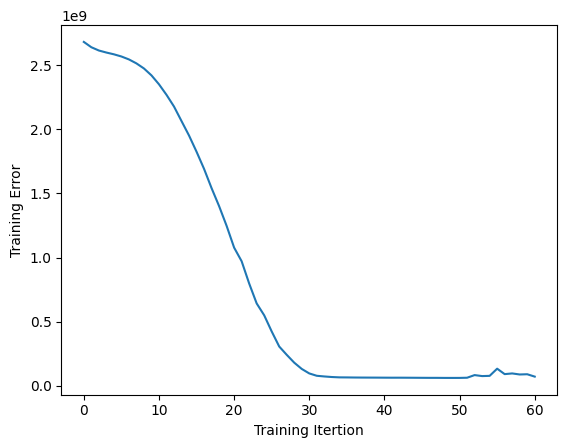

In [40]:
# !pip install matplotlib
import matplotlib.pyplot as plt

if not retrieval:
  plt.plot(regr.loss_curve_);
  plt.xlabel("Training Itertion")
  plt.ylabel("Training Error")
  min(regr.loss_curve_)

Based on the above plot the model does seem converged / to have converged quite quckly.

Now lets test the model !!! (we will look at the root mean squared error in calories to begin with), its lazy we can do better. If you look at the median absolute error it does suggest theres some outliers in the test result, its worth seeing what the recipie for the worst performances is and to try and diagnose why this is not working 

In [41]:
delta_test= regr.predict(vec_X_test) - y_test[:smaller].flatten()
print(delta_test.shape)
rmse_test = np.sqrt(np.mean((delta_test) ** 2))
rmae_test = np.sqrt(np.median((delta_test) ** 2))

rmse_test, rmae_test

(7680,)


(29497.212213322855, 3395.814863656529)

In [42]:
delta_train = regr.predict(vec_X_train) - y_train[:smaller].flatten()
print(delta_train.shape)
rmse_train = np.sqrt(np.mean((delta_train) ** 2))
rmae_train = np.sqrt(np.median((delta_train) ** 2))

rmse_train, rmae_train

(35866,)


(11593.380738328713, 3205.318659565688)

In [43]:
delta_validation = regr.predict(vec_X_val) - y_val[:smaller].flatten()
print(delta_validation.shape)
rmse_validation = np.sqrt(np.mean((delta_validation)**2))
rmae_validation = np.sqrt(np.median((delta_validation)**2))

rmse_validation, rmae_validation

(7686,)


(12064.262197257627, 3261.398608458087)

In [ ]:
import seaborn as sns
import pandas as pd


labels = ["train absolute error dist"] * len(delta_train) + ["test absolute error"] * len(delta_test) 
rmse_train_all = list(np.abs(delta_train)) + list(np.abs(delta_test))

df = pd.DataFrame({
    "rmse": rmse_train_all,
    "labels": labels
})

sns.boxplot(data=df, x="rmse", y="labels")

This is the error in kCal per 100g , pretty easy quantity to interpret.

We can see that the test error is at 145 kcals per 100g whilst the train error is 20kcal per 100g thus this model does not generalise well (it overfits). Maybe we need: 

* Better recipie specific embeddings
* Maybe using image data is better
* The way we encoded recipies into sentences might have not been the smartest
* We could try training the model for longer.

# How do we use this for a new recipeie

For a new recipie we  need to first write a function that transforms it into a similar-ish sentence format to what we have used in training then we pass it through the transformer sentence embedder and the pass it through the trained model it for example:

In [ ]:
ingredients_sentence = ["greasy-pizza, fish, fried-potatoes"]
vector = model.encode(ingredients_sentence)
prediction = regr.predict(vector)
prediction

In [ ]:
ingredients_sentence = ["broccoli, lettuce, water"]
vector = model.encode(ingredients_sentence)
prediction = regr.predict(vector)
prediction

In [ ]:
ingredients_sentence = ["onion, tomato, squash"]
vector = model.encode(ingredients_sentence)
prediction = regr.predict(vector)
prediction

In [ ]:
ingredients_sentence = ["tomato, spinach, ginger"]
vector = model.encode(ingredients_sentence)
prediction = regr.predict(vector)
prediction



Think about the above results, they are not quite right and some are quite wrong/unintuitve thus it seems this model hasnt learned anything good unfortunately. 

Maybe:

* I processed the data wrong ?
* We need more data ?
* We need to train for longer

